In [1]:
import json
import os
import fnmatch
import pandas as pd
import numpy as np
from pprint import pprint
import matplotlib.pyplot as plt
import seaborn as sns
import sys

%matplotlib inline
sns.set()

In [2]:
if os.sys.platform == 'win32':
    sys.path.append(r'C:\Users\msladkov\Dropbox\Projects\sam_ml')
else:
    sys.path.append('/Users/sladkovm/Dropbox/Projects/sam_ml')

from sam_ml import RemoveOutliers

## Read in data

In [3]:
def load_data(data_path, f_name='activity-*.json'):
    '''returns DataFrame constructed from json object found in data_path matching the f_name string'''
    
    file_list = [file for file in os.listdir(data_path) if fnmatch.fnmatch(file, 'activity-*.json')]

    data_list = []
    for file in file_list:
        f_name = os.path.join(data_path, file)
        with open(f_name, 'r', encoding='utf-8') as f:
            content = json.load(f)
            data_list.append(content)
        
    df = pd.DataFrame(data_list)
    
    return df

In [4]:
%%time

if os.sys.platform == 'win32':
    data_path = os.path.normpath(r'C:\Users\msladkov\Dropbox\Projects\sam_ml\data\brussels-data')
else:
    data_path = os.path.normpath(r'/Users/sladkovm/Dropbox/Projects/sam_ml/data/seattle-data')
    
df = load_data(data_path)

CPU times: user 1.64 s, sys: 910 ms, total: 2.55 s
Wall time: 3.66 s


## Fill NA
* all float64 are filled with -1.0 to indicate unrealistic value

In [44]:
# _ = df.copy().select_dtypes(['float64']).fillna(value=-1.0)
# df.loc[_.index, _.columns] = _

# _ = df.copy().select_dtypes(['int64']).fillna(value=-1.0)
# df.loc[_.index, _.columns] = _

## Remove outliers

In [5]:
ro = RemoveOutliers()
ro = ro.fit(df[['distance', 'average_speed', 'max_speed', 'elapsed_time', 'moving_time']])
df = ro.transform(df)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7847 entries, 2 to 8165
Data columns (total 53 columns):
achievement_count         7847 non-null int64
athlete                   7847 non-null object
athlete_count             7847 non-null int64
average_cadence           2143 non-null float64
average_heartrate         2477 non-null float64
average_speed             7847 non-null float64
average_temp              3399 non-null float64
average_watts             6979 non-null float64
comment_count             7847 non-null int64
commute                   7847 non-null bool
device_watts              7846 non-null object
distance                  7847 non-null float64
elapsed_time              7847 non-null int64
elev_high                 7847 non-null float64
elev_low                  7847 non-null float64
end_latlng                7847 non-null object
external_id               7847 non-null object
flagged                   7847 non-null bool
gear_id                   4253 non-null object


### Add stop_to_move_ratio column

In [ ]:
# Find all absent moving time and replace with a value of elapsed time
# df.loc[df['moving_time']<=0, 'moving_time'] = df.loc[df['moving_time']<=0, 'elapsed_time']

# Find all elapsed_time smaller than moving_time and set the equal
# df.loc[df['elapsed_time'] < df['moving_time'],
#        'elapsed_time'] = df.loc[df['elapsed_time'] < df['moving_time'], 'moving_time']

# Calculate ratio
# df['stop_to_move_ratio'] = (df['elapsed_time'] - df['moving_time'])/df['moving_time']

# Set ration >1.0 to 1.0 (the stop time == moving time)
# df.loc[df['stop_to_move_ratio']>1.0, 'stop_to_move_ratio'] = 1.0

In [ ]:
# df = df[df['stop_to_move_ratio']<1.0].copy()

## Split data into Model and Not Categorized set

All activities labeled as *commute* are treated as a ground truth set **Commute**

In order to get a ground truth **Training** set we will make an assumption that all activities with *device_watts* and not labeled as *commute* are the actual training activities.

The rationale behind this assumption is simple - the powermeter is expensive piece of equipment and those people, who have it, most likely use it for training. For those situations where one would go to work via the training route and will come back via the commute route (as I often do) we rely on the deligence of the riders to label the return route as a commute (as I do).

With these two assumptions at hand we can extract a model set from the given data, fit the classifier on this data set and use the classifier to label the rest of the data.

Stepwise actions:
* find all activivities labeled as commute and labels them as 'c'
* find all activities with powermeter, but labeled as not a comute and label them as 't' - training
* the rest of the activities should be labeled as 'nc' - non categorized

In [6]:
idx_commute = df['commute']
idx_not_commute = df['device_watts'] & ~df['commute']

In [7]:
df['label'] = 'nc'
df.loc[idx_commute, 'label'] = 'c'
df.loc[idx_not_commute, 'label'] = 't'
df_model = df[df['label']!='nc'].reset_index(drop=True)
df_nc = df[df['label']=='nc'].reset_index(drop=True)

In [8]:
pprint('{} commute'.format(len(df[df['label']=='c'])))
pprint('{} training'.format(len(df[df['label']=='t'])))
pprint('{} not categorized'.format(len(df[df['label']=='nc'])))

'1305 commute'
'811 training'
'5731 not categorized'


## Scale and Split model data into Training and Test set

In [9]:
from sklearn import preprocessing
from sklearn import model_selection

training_features = ['distance', 'average_speed', 'max_speed', 'has_heartrate']

scaler = preprocessing.StandardScaler().fit(df_model[training_features])
# scaler = preprocessing.RobustScaler(with_centering=True,
#                                     with_scaling=True,
#                                     quantile_range=(25.0, 75.0)).fit(df_model[training_features])

scaled_data = scaler.transform(df_model[training_features])

train, test, y_train, y_test = model_selection.train_test_split(scaled_data,
                                                                df_model['label'].values,
                                                                test_size=0.2,
                                                                random_state=1)

In [10]:
df_train = pd.DataFrame(train, columns=training_features)
df_train['label'] = y_train

df_test = pd.DataFrame(test, columns=training_features)
df_test['label'] = y_test

## Examine training data using the pairwise plot

* The major conclusion is that *has_heartrate* alone is not a sufficient discriminant between **commute** and **training** classes. Luckily it still shows some bias (prensence of heartrate) in the **training** class
* There is a strong correlation between all tree continuosu variables hinting that effectively we have less than 4 features
* Each of the continuos variable does not show a significant difference in **mean** and/or **std** to make it a dominant classifier feature
* In conclusion - it would be naive to expect a stellar classifier performance with this set of features, but better than dummyClassifier should be possible.
* All tree continuous varibles (bear in mind the strong cross-correlation) do hint on effective separability between classes
* The *has_heartrate*, on the other hand, appears to be a very weak discriminant feature.

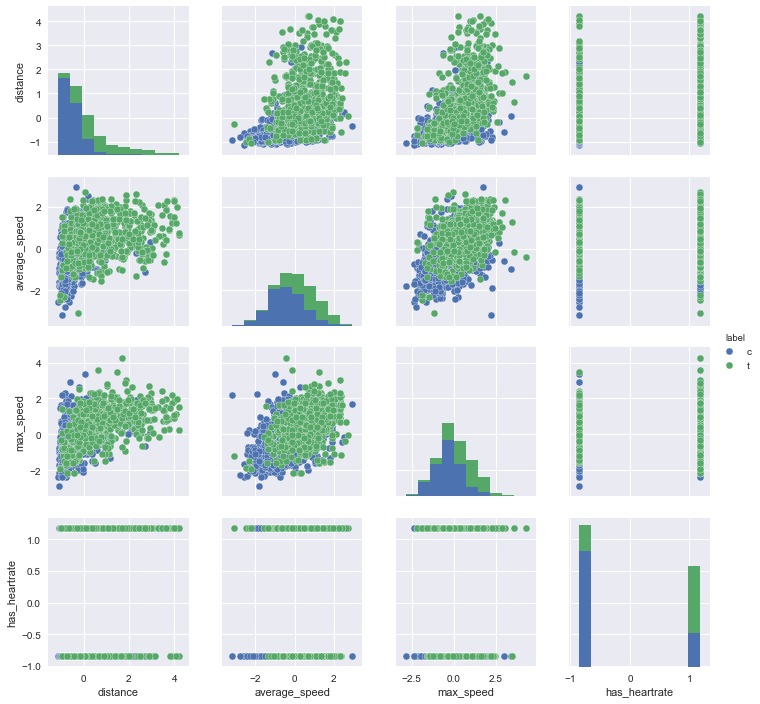

In [11]:
# f, ax = plt.subplots(1, figsize=(12,6))
# pd.plotting.parallel_coordinates(df_train, 'label', ax=ax)
sns.set()
sns.set_context(font_scale=3)
ax = sns.pairplot(df_train, hue='label')
# plt.tight_layout()
plt.savefig('pairwise.png')

## Perform PCA analysis and visualize the ordered features

* No vanishing dimensions in the transformed feature set hinting that we have not enough independent observations 
* Classification results are likely to be dominated by the strong first component. This is also confirmed by the pairwise plot, where only first component shows strong separation in **mean** between classes
* The rest of the components do not appear to be separable meaning we are most likely have a 1-feature classifier. This is confirmed by the parallel coordinates plot

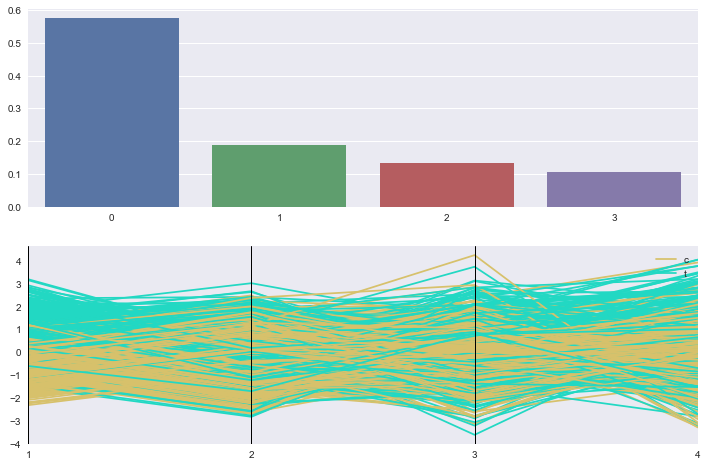

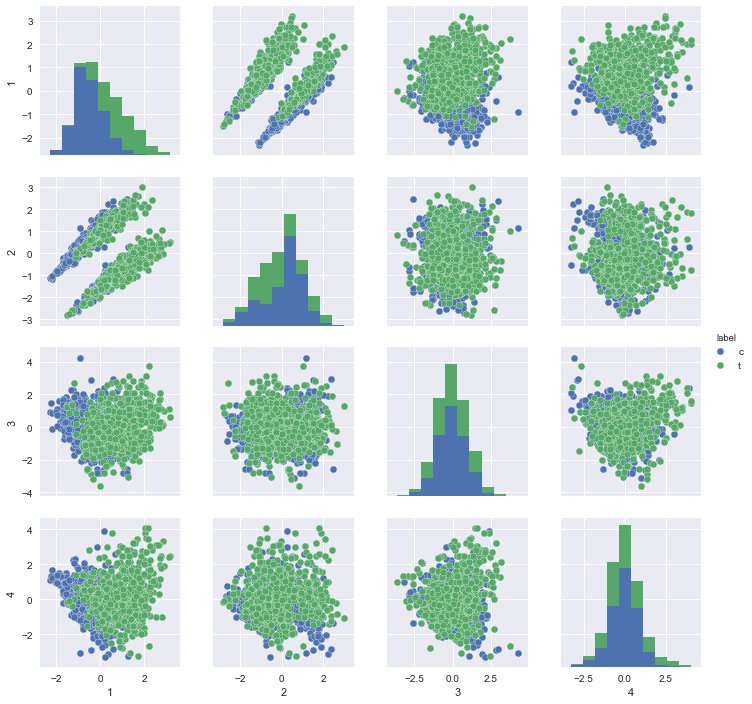

In [12]:
from sklearn.decomposition import PCA
pca = PCA(whiten=True).fit(train)
df_pca = pd.DataFrame(pca.fit_transform(train), columns=['1', '2', '3', '4'])
df_pca['label'] = y_train

f, ax = plt.subplots(2,1, figsize=(12,8))

sns.barplot(np.arange(len(pca.explained_variance_ratio_)),
            pca.explained_variance_ratio_, ax=ax[0])


pd.plotting.parallel_coordinates(df_pca, 'label', ax=ax[1])



ax = sns.pairplot(df_pca, hue='label')

## Visualize using t-SNE

In [13]:
from sklearn.manifold import TSNE

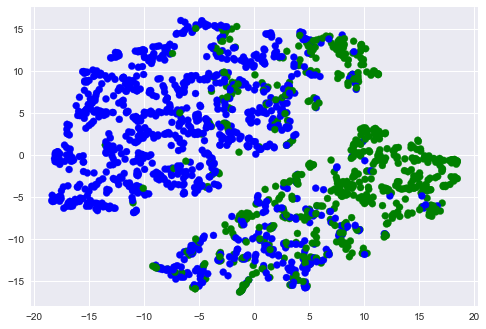

In [14]:
tsne = TSNE(n_components=2, random_state=0, init='pca')
tmp = tsne.fit_transform(train)
s = pd.Series(y_train)
plt.scatter(x=tmp[:,0], y=tmp[:,1], c=s.map({'c':'b', 't':'g'}))
# plt.scatter(x=tmp[:,0], y=tmp[:,1] )

## Get transformation coefficients PCA

In [15]:
feature_contributions = pca.inverse_transform(np.eye(train.shape[1]))

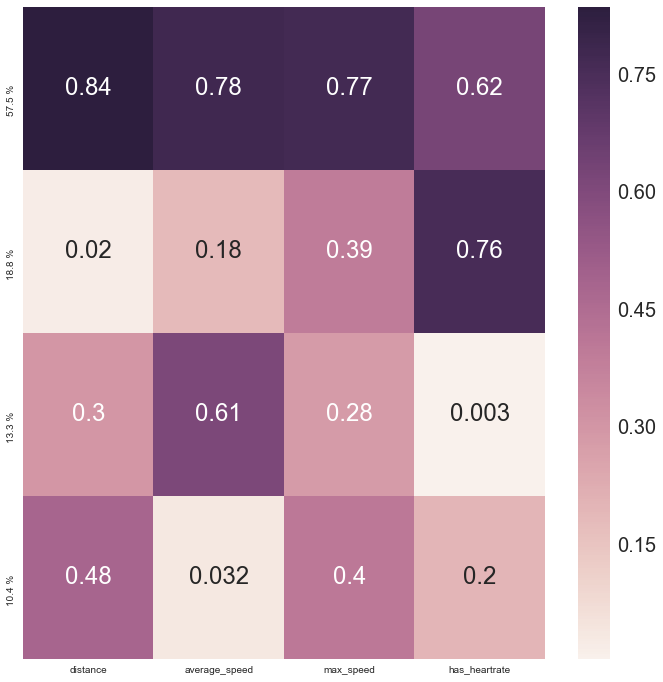

In [16]:
f, ax = plt.subplots(1, figsize=(10,10))

ylabels = ['{:.1f} %'.format(x*100) for x in pca.explained_variance_ratio_]

sns.set(font_scale=2)
sns.heatmap(np.abs(feature_contributions), annot=True,
           xticklabels=training_features,
           yticklabels=ylabels,
           ax=ax)
# plt.ylabel('Explained variance', fontsize=16.0)
# plt.xlabel('Original features', fontsize=16.0)

f.tight_layout()
f.savefig('pca.png')

## Cross validation analysis of the SVM

In [17]:
from sklearn import svm
clf = svm.SVC(kernel='linear', C=1.0)
scores = model_selection.cross_val_score(clf, scaled_data,
                                         df_model['label'].values, 
                                         cv=5)
print('Accuracy: {:.2f} +/- {:.2f}'.format(scores.mean(), 2*scores.std()))

Accuracy: 0.84 +/- 0.09


## Classify with SVM

In [18]:
from sklearn import svm
clf = svm.SVC(kernel='linear').fit(train, y_train)
clf.score(test, y_test)

0.87971698113207553

## Verify fit on validation set and visualize the results

In [20]:
validation_set = pd.DataFrame(test, columns=training_features)

In [21]:
validation_set['label'] = y_test
validation_set['predictions'] = clf.predict(test)
validation_set['error'] = validation_set['label'] != validation_set['predictions']
validation_set.head()

,distance,average_speed,max_speed,has_heartrate,label,predictions,error
0,0.025318,0.019734,1.521802,1.173681,t,t,False
1,3.889092,1.287952,2.503106,1.173681,t,t,False
2,-0.764875,-0.173354,-0.947285,1.173681,c,c,False
3,-0.080059,-0.415394,-0.567426,1.173681,c,c,False
4,2.329250,0.916280,1.015323,1.173681,t,t,False


## Confusion matrix

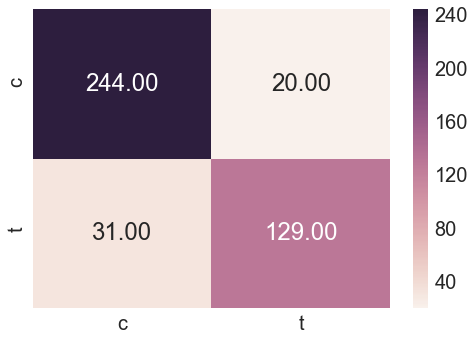

In [22]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test,
                      validation_set['predictions'].values, ['c', 't'])
sns.heatmap(cm, annot=True, fmt='.2f',
            xticklabels=['c', 't'],
            yticklabels=['c', 't'])

In [23]:
def decision_boundary(clf, range_x=(-3.0, 3.0)):
    w = clf.coef_[0]
    w = clf.coef_[0]
    a = -w[0] / w[1]
    xx = np.linspace(range_x[0], range_x[1])
    yy = a * xx - (clf.intercept_[0]) / w[1]
    return (xx, yy)

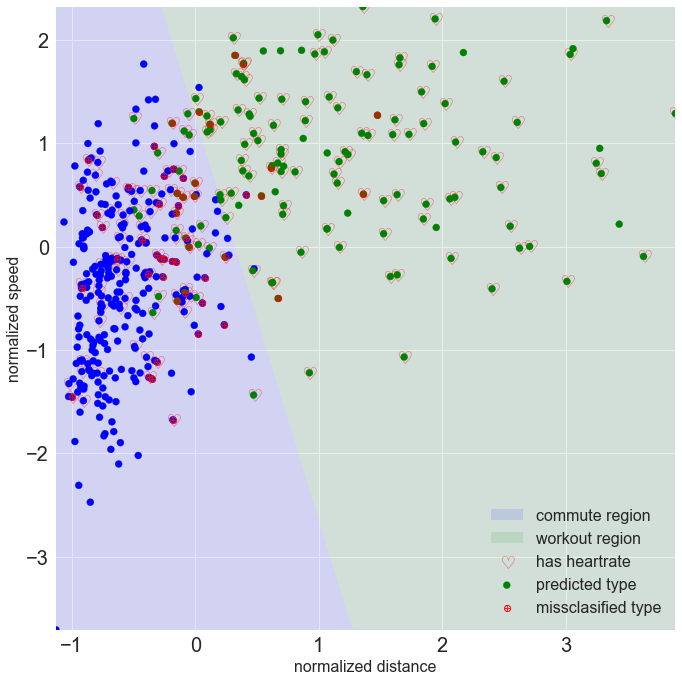

In [24]:
(xx, yy) = decision_boundary(clf,
                             range_x = (validation_set['distance'].min(),
                                        validation_set['distance'].max()))
colors={'c':'b', 't':'g'}

f, ax = plt.subplots(1, figsize=(10,10))

ax.fill_between(xx, validation_set['average_speed'].min(), yy,
               facecolor='blue',
               alpha=0.1,
               label='commute region')

ax.fill_between(xx, yy, validation_set['average_speed'].max(),
               facecolor='green',
                alpha=0.1,
                label='workout region')


X='distance'
Y='average_speed'

## plot hearts
ax.scatter(x=validation_set.loc[df_test['has_heartrate']>0, X],
            y=validation_set.loc[df_test['has_heartrate']>0,  Y],
            marker=r'$\heartsuit$',
            s=200,
            facecolor='red',
            edgecolor='red',
            alpha=0.3,
          label='has heartrate')

ax.scatter(x=validation_set[X],
          y=validation_set[Y],
          c =validation_set['predictions'].map(colors),
          label='predicted type')



ax.scatter(x=validation_set.loc[validation_set['error'], X],
           y=validation_set.loc[validation_set['error'],  Y],
           marker=r'$\bigoplus$',
           c='red',
          label='missclasified type')

plt.xlabel('normalized distance', fontsize=16.0)
plt.ylabel('normalized speed', fontsize=16.0)
plt.legend(fontsize=16.0)

plt.ylim((validation_set['average_speed'].min(), validation_set['average_speed'].max()))
plt.xlim((validation_set['distance'].min(), validation_set['distance'].max()))

f.tight_layout()
f.savefig('workout_commute_classifier.png')

## Run prediction on the full dataset

In [25]:
# scale features
f_scaled = scaler.fit_transform(df[training_features])
# run the classifier
df['predictions'] = clf.predict(f_scaled)

df.head()

,achievement_count,athlete,athlete_count,average_cadence,average_heartrate,average_speed,average_temp,average_watts,comment_count,commute,...,total_elevation_gain,total_photo_count,trainer,type,upload_id,utc_offset,weighted_average_watts,workout_type,label,predictions
2,0,"{'follower': None, 'username': None, 'created_...",1,NaN,NaN,5.310,NaN,82.1,0,True,...,88.4,0,False,Ride,1102415994,-25200,NaN,10.0,c,c
3,1,"{'follower': None, 'username': 'jpottle', 'cre...",1,74.1,134.7,5.922,18.0,166.7,0,False,...,1130.0,0,False,Ride,1102416555,-25200,NaN,NaN,nc,t
4,0,"{'follower': None, 'username': 'simon_douwes',...",1,61.9,NaN,5.255,19.0,124.6,0,False,...,78.0,0,False,Ride,1102427450,-25200,NaN,NaN,nc,c
5,3,"{'follower': None, 'username': 'al_hasse', 'cr...",1,76.4,140.6,5.161,11.0,107.0,0,False,...,157.0,0,False,Ride,1102438148,-25200,NaN,NaN,nc,c
6,4,"{'follower': None, 'username': None, 'created_...",1,NaN,NaN,6.991,25.0,143.7,0,False,...,484.0,0,False,Ride,1102440962,-25200,NaN,10.0,nc,c


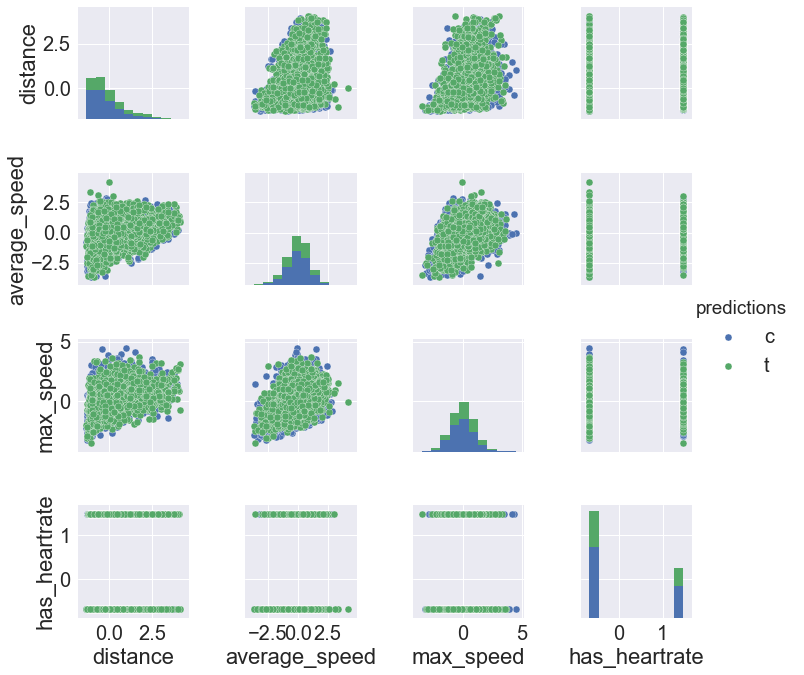

In [26]:
df_pred = pd.DataFrame(f_scaled, columns=training_features)
df_pred['predictions'] = df['predictions']
ax = sns.pairplot(df_pred, hue='predictions')

In [27]:
df[['id', 'predictions']].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7847 entries, 2 to 8165
Data columns (total 2 columns):
id             7847 non-null int64
predictions    7847 non-null object
dtypes: int64(1), object(1)
memory usage: 503.9+ KB


In [28]:
df[['id', 'predictions']].to_csv('../results/seattle_v1.csv', index=False, float_format='%s')
df[['id', 'predictions']].to_json('../results/seattle_v1.json', orient='records')

## Clustering using Kmeans

In [ ]:
# from sklearn import metrics
# from sklearn.cluster import KMeans

# estimator = KMeans(init='k-means++', n_clusters=2)
# estimator.fit(df_reduced)

# estimator.labels_
# df_reduced['labels'] = estimator.labels_
# df_reduced['commute'] = df['commute']

## Plotting results

In [ ]:
# color = {0: 'green', 1: 'blue'}
# mark = {0: 'c', 1: 't'}

# miss = df_reduced['labels'].astype(bool) & df_reduced['commute']

# fig = plt.figure()
# ax = fig.add_subplot(111)
# ax.scatter(x=df_reduced[0],
#            y=df_reduced[1],
#            c=[color[x] for x in df_reduced['labels']])
# ax.hold=True
# ax.scatter(x=df_reduced[0].loc[miss],
#            y=df_reduced[1].loc[miss],
#            c='red',
#            marker='x')


# from mpl_toolkits.mplot3d import Axes3D
# fig = plt.figure()
# ax = fig.add_subplot(111, projection='3d')
# ax.scatter(xs=df_reduced[0],
#            ys=df_reduced[1],
#            zs=df_reduced[2],
#            c=[color[x] for x in df_reduced['labels']])